Importaciones

In [153]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import calendar
import numpy as np

#### Carga y transformacion de datos

Formato ancho

In [154]:
# Carga de datos
piezo_df = pd.read_csv(
    '../data/processed/03_daily/piezo-data_SDH1PS01_daily.csv', 
    parse_dates=['Timestamps'], index_col='Timestamps',
    usecols=['Timestamps',
             'depth_m']
    )

soil_df = pd.read_csv(
    '../data/processed/03_daily/soil-data_z6-25818_daily.csv', 
    parse_dates=['Timestamps'], index_col='Timestamps',
    usecols=['Timestamps',
             'TEROS12_15cm_water-content_m3/m3',
             'TEROS12_30cm_water-content_m3/m3',
             'TEROS12_48cm_water-content_m3/m3',
             'TEROS12_15cm_soil-temperature_degree_C',
             'TEROS12_30cm_soil-temperature_degree_C',
             'TEROS12_48cm_soil-temperature_degree_C']
    )

# Diccionario de mapeo para limpiar nombre de columna del piezometro
# Estructura: sensor_profundidad_variable_unidad
piezo_rename_map = {'depth_m': 'Piezometer_NA_groundwater-depth_m'}

# Renombrado de columnas a partir de diccionario de mapeo
piezo_df = piezo_df.rename(columns=piezo_rename_map)

# Union de datasets en formato ancho
wide_df = pd.merge(piezo_df, soil_df, left_index=True, right_index=True, how='inner')

Formato largo

In [155]:
# Transformacion de datos a formato largo
long_df = wide_df.reset_index().melt(
    id_vars='Timestamps',       # Columna id
    var_name='Metadata',        # Columna temporal en formato sensor_profundidad_variable
    value_name='Value'          # Nombre columna que almacenara los valores 
    )

# Division de la columna de metadatos usando guiones bajos
metadata_split = long_df['Metadata'].str.split('_', expand=True)

# Generacion de nuevas columnas a partir del texto dividido
long_df['Sensor'] = metadata_split[0]
long_df['Depth'] = metadata_split[1]
long_df['Variable'] = metadata_split[2]
long_df['Unit'] = metadata_split[3]

# Eliminacion de la columna metadata
long_df = long_df.drop('Metadata', axis=1)

Transformaciones para serie temporal

In [156]:
# Creacion de columnas de etiquetado (fines esteticos)
long_df['Variable-label'] = long_df['Variable'].map({
    'groundwater-depth': 'Prof. nivel freático (m)',
    'water-content': 'Contenido de agua (m³/m³)',
    'soil-temperature': 'Temperatura (°C)'
})
long_df['Depth-label'] = long_df['Depth'].str.replace('cm', ' cm').replace('NA', 'NA')

# Reorden de columnas en df largo
long_order = ['Timestamps', 'Sensor', 'Depth', 'Depth-label', 'Variable', 'Variable-label', 'Unit', 'Value']
long_df = long_df.reindex(columns=long_order)

# Definicion de listas para ordenar profundidades en graficas
soil_depth_order = ['15 cm', '30 cm', '48 cm']
full_depth_order = ['15 cm', '30 cm', '48 cm', 'NA']


Trasnformaciones para correlaciones (cruzadas y moviles)

In [157]:
# Diferenciacion de datos para generar series temporales estacionarias
# Estos datos requieren diferenciacion de segundo orden
diff_wide_df = wide_df.diff().diff().dropna()

# Definicion del rango de dias de desfase a analizar
lag_days = 15
# N dias hacia el pasado, N dias + 1 hacia el futuro (inclue el dia 0)
lags = np.arange(-lag_days, lag_days+1)

# Largo de la ventana movil (dias)
window_days = 45

# Nombres de las columnas a correlacionar
groundwater_col = 'Piezometer_NA_groundwater-depth_m'

# Definicion de diccionarios para iterar
variables_map = {
    'Contenido de agua (m³/m³)': 'water-content_m3/m3',
    'Temperatura (°C)': 'soil-temperature_degree_C'
}
depth_map = {
    '15 cm': '15cm', 
    '30 cm': '30cm', 
    '48 cm': '48cm'
}

# Defincion de objetos para almacenar resultados
lag_results = []
rolling_list = []

# Calculo de limites de confianza al 95%
n_obs = len(diff_wide_df)
conf_cross_corr = 1.96 / np.sqrt(n_obs)
conf_rolling_corr = 1.96 / np.sqrt(window_days)


# Bucle principal: itera sobre las variables medidas
for var_label, var_suffix in variables_map.items():
    
    # Bucle secundario: itera sobre las profundidades de sensor
    for depth_label, depth_suffix in depth_map.items():

        # Construccion del nombre de la columna con datos de suelo actual
        col_name = f"TEROS12_{depth_suffix}_{var_suffix}"
        
        # Calculo de la correlacion movil entre nivel freatico y la variable actual a la prof. actual
        r_series = diff_wide_df[groundwater_col
                                ].rolling(window=window_days
                                          ).corr(diff_wide_df[col_name])

        # Almacenamiento de datos en un dataframe temporal (correlacion movil)
        rolling_df = r_series.to_frame(name='Rolling-correlation')
        rolling_df['Variable-label'] = var_label
        rolling_df['Depth-label'] = depth_label

        # Almacenamiento del df actual en una lista
        rolling_list.append(rolling_df)

        # Bucle terciario: itera sobre cada lag
        for lag in lags:

            # Calculo de la correlacion entre nivel freatico y la variable 
            # actual a la profundidad actual en el lag actual
            corr = diff_wide_df[groundwater_col
                                ].corr(diff_wide_df[col_name
                                                    ].shift(lag))

            # Almacenamiento de resultados en un diccionario (correlaciones cruzadas)
            lag_results.append({
                'Variable-label': var_label,
                'Depth-label': depth_label,
                'Lag': lag,
                'Cross-correlation': corr
            })

# Transformacion de resultados a dataframes
cross_corr_df = pd.DataFrame(lag_results)
rolling_corr_df = pd.concat(rolling_list, axis=0).dropna()

Transformaciones para scatterplot

In [158]:
# Creacion de un df largo sin datos piezometricos
soil_long_df = long_df[long_df['Sensor'] == 'TEROS12'].set_index('Timestamps')

# Creacion de una columna con datos piezometricos
piezo_col = long_df[long_df['Sensor'] == 'Piezometer'].set_index('Timestamps')['Value']

# Union de la columna al df de suelos
scatter_df = soil_long_df.merge(
    piezo_col.rename('Groundwater-depth-m'),
    left_index=True,
    right_index=True)

# Creacion de una columna con el valor del mes
scatter_df['Month'] = scatter_df.index.month


Transformaciones para diagrama de Hovmoller

In [159]:
# Genera un array de numeros entre 0.15 y 0.48 separados cada 0.01 m 
fine_depths = np.arange(0.15, 0.49, 0.01)

# Lista para almacenar resultados
processed_frames = []

# Bucle principal: itera sobre las variables medidas
for var_label, var_suffix in variables_map.items():
    
    # Creacion de una lista con nombres de columna para la variable actual
    cols_list = [f'TEROS12_{depth_suffix}_{var_suffix}'
                 # Itera sobre cada profundidad
                 for depth_suffix in depth_map.values()]
    
    # Transposicion de los datos anchos. Nuevo formato:
    # filas: profundidades - columnas: fechas - celdas: valores de la variable actual
    matrix = wide_df[cols_list].T

    # Renombrado del indice de la matriz
    matrix.index = [0.15, 0.30, 0.48]

    # Creacion de filas intermedias cada 0.01 m (vacias)
    matrix_expanded = matrix.reindex(
        matrix.index.union(fine_depths)).sort_index()
    
    # Interpolacion de valores en filas intermedias
    matrix_interpolated = matrix_expanded.interpolate(method='index')

    # Eliminacion de valores repetidos generados en la interpolacion
    matrix_clean = matrix_interpolated.loc[fine_depths]

    # Transformacion a formato largo
    long_matrix = matrix_interpolated.stack().reset_index()

    # Renombrado de columnas
    long_matrix.columns = ['Depth_m', 'Date', 'Value']
    long_matrix['Variable-label'] = var_label
    
    # Almacenamiento del df largo actual en una lista
    processed_frames.append(long_matrix)

# Concatenacion de los df largos contenidos en la lista (1 por variable)
hovmoller_df = pd.concat(processed_frames, ignore_index=True)


#### Visualizacion

Definicion de estilo de graficos

In [160]:
# Estilo global de seaborn
sns.set_theme(
    context='notebook',     # Escalado para visualizacion web
    style='white',          # Fondo blanco sin ticks en los ejes
    font='sans-serif'
    )

# Grillas
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

# Paleta de colores
viridis = sns.color_palette("viridis_r", n_colors=3)
palette_dict = {
    '15 cm': viridis[0],    # Verde claro
    '30 cm': viridis[1],    # Verde azulado
    '48 cm': viridis[2],    # Azul
    'NA': 'black'           # Negro
}

##### Series temporales

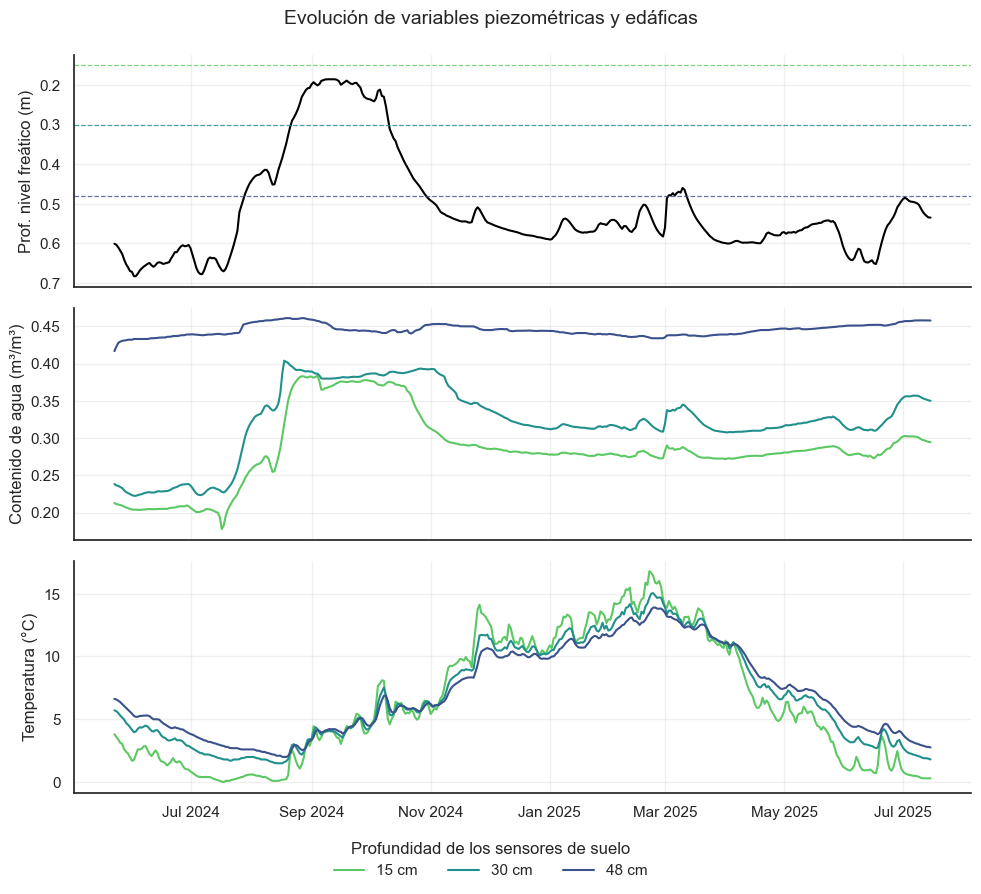

In [161]:
# Creacion de la figura base
time_series = sns.relplot(
    data=long_df,
    x='Timestamps',
    y='Value',
    hue ='Depth-label',             # Diferencia colores segun profundidad
    row='Variable-label',           # Una fila por cada variable
    palette=palette_dict,
    hue_order=full_depth_order,
    kind='line',                    # Grafico de lineas
    height=3,
    aspect=3,
    facet_kws={'sharey': False, 'sharex':True}      # Eje Y independiente, eje X compartido
)

# Eliminacion de elementos incluidos por defecto
time_series.set_titles('')
time_series.set_xlabels('')
time_series._legend.remove()

# Iteracion sobre facets para aplicar estilos particulares
for i, (ax, title) in enumerate(zip(time_series.axes.flat, time_series.row_names)):

    # Etiquetado de los ejes Y de cada facet
    ax.set_ylabel(title, fontweight='normal')

    # Formateo de fechas en el eje X
    date_format = mdates.DateFormatter('%b %Y')
    ax.xaxis.set_major_formatter(date_format)

    # Configuracion particular para el primer facet
    if 'Prof. nivel freático (m)' in title:
        
        # Invierte el eje Y
        ax.invert_yaxis()

        # Traza profundidad de sensores de suelo como lineas horizontales
        sensor_depths_m = [0.15, 0.30, 0.48]
        for depth, label in zip(sensor_depths_m, soil_depth_order):
            ax.axhline(y=depth, color=palette_dict[label], linestyle='--', linewidth= 0.9, alpha=0.8)

# Eliminacion de la leyenda de objetos asociados al piezometro
handles, labels = time_series.axes[0,0].get_legend_handles_labels()
clean_handles = [h for h, l in zip(handles, labels) if l != 'NA']
clean_labels = [l for l in labels if l != 'NA']

# Creacion de nueva leyenda
time_series.figure.legend(
    handles=clean_handles,
    labels=clean_labels,
    loc='lower center',
    bbox_to_anchor=(0.5, 0),
    ncol=3,
    title="Profundidad de los sensores de suelo",
    frameon=False
)

# Establecimiento de titulo
time_series.figure.suptitle("Evolución de variables piezométricas y edáficas",
                            x=0.5, y=0.98, fontsize=14)

# Ajustes de espaciado
plt.tight_layout()
plt.subplots_adjust(top=0.93, bottom=0.11) # Ajusta espacio disponible para facets

plt.show()

##### Correlaciones cruzadas

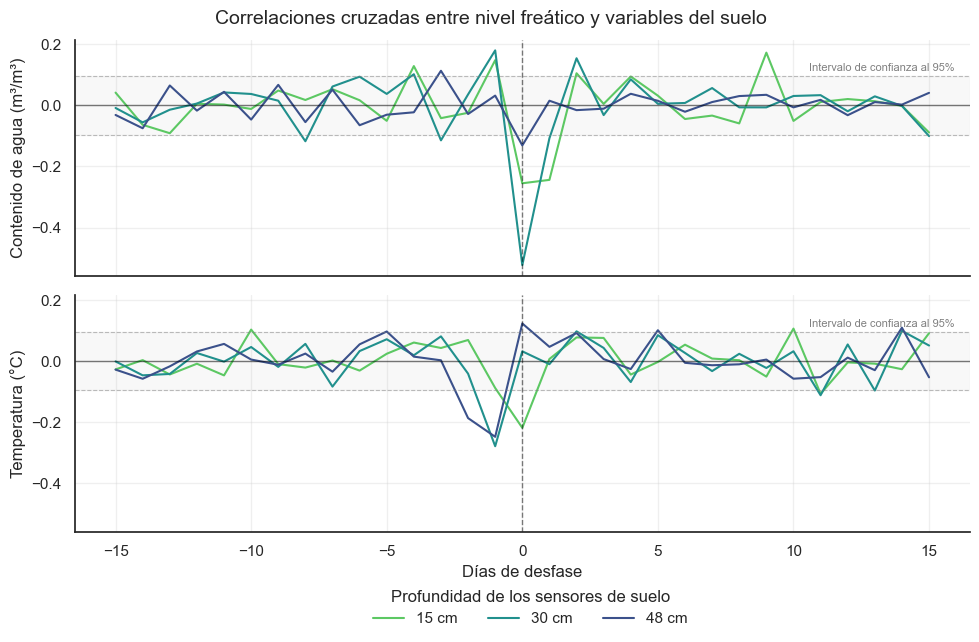

In [162]:
# Creacion de la figura base
cross_corr = sns.relplot(
    data=cross_corr_df,
    x='Lag',
    y='Cross-correlation',
    hue='Depth-label',
    row='Variable-label',
    palette=palette_dict,
    kind='line',
    height=3,
    aspect=3
)

# Eliminacion de elementos incluidos por defecto
cross_corr.set_titles('')
cross_corr.set_xlabels('')
cross_corr._legend.remove()

# Iteracion sobre facets para etiquetar los ejes Y
for ax, title in zip(cross_corr.axes.flat, cross_corr.row_names):
    ax.set_ylabel(title)

# Etiquetado del eje X
ax.set_xlabel('Días de desfase')
# Trazado de lineas de referencia
for ax in cross_corr.axes.flat:

    # Trazado de lineas 0, 0
    ax.axvline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)
    ax.axhline(0, color='black', linestyle='-', linewidth=1, alpha=0.5)

    # Trazado de limites de confianza
    ax.axhline(conf_cross_corr, color='gray', linestyle='--', linewidth=0.8, alpha=0.5)
    ax.axhline(-conf_cross_corr, color='gray', linestyle='--', linewidth=0.8, alpha=0.5)
    ax.axhspan(-conf_cross_corr, conf_cross_corr, color='gray', alpha=0.05)

    # Anotacion del limite de confianza
    ax.text(
        x=0.82,
        y=0.87,
        s='Intervalo de confianza al 95%',
        transform=ax.transAxes,
        fontsize=8,
        color='gray'
    )  

# Creacion de nueva leyenda
cross_corr.figure.legend(
    loc='lower center',
    bbox_to_anchor=(0.54, -0.07),
    ncol=3,
    title="Profundidad de los sensores de suelo",
    frameon=False
)

# Establecimiento de titulo
cross_corr.figure.suptitle("Correlaciones cruzadas entre nivel freático y variables del suelo", 
                           x=0.5, y=0.98, fontsize=14)

# Ajustes de espaciado
plt.tight_layout()
plt.subplots_adjust(top=0.93, bottom=0.11) # Ajusta espacio disponible para facets

plt.show()

##### Graficos de dispersion mensuales

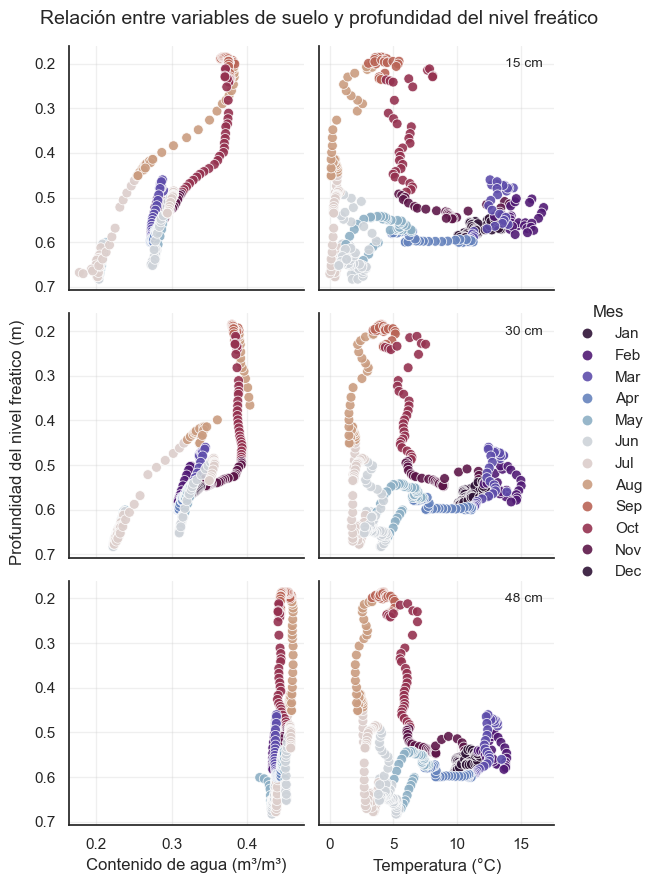

In [163]:
# Creacion de la figura base
scatter_plot = sns.relplot(
    data=scatter_df,
    x='Value',                          # Eje X: variables de suelo
    y='Groundwater-depth-m',            # Eje Y: profundidad nivel freatico
    hue='Month',                        # Coloreado por mes
    row='Depth-label',                  # Una fila por profundidad
    col='Variable-label',               # Una columna por variable
    row_order=soil_depth_order,
    palette='twilight_shifted',         # Paleta ciclica
    kind='scatter',
    height=3,
    aspect=1,
    facet_kws={'sharey': True, 'sharex': 'col'},    # Eje Y compartido, Eje X: compartido por columnas
    s=50,
    alpha=0.9,
    legend='full'
)

# Eliminacion de elementos incluidos por defecto
scatter_plot.set_titles('')
scatter_plot.set_xlabels('')
scatter_plot.set_ylabels('')

# Etiquetado del eje X
scatter_plot.axes[-1, 0].set_xlabel("Contenido de agua (m³/m³)")
scatter_plot.axes[-1, 1].set_xlabel("Temperatura (°C)")

# Inversion del eje Y (+ margen)
y_min, y_max = scatter_df['Groundwater-depth-m'].min(), scatter_df['Groundwater-depth-m'].max()
padding = (y_max - y_min) * 0.05
scatter_plot.set(ylim=(y_max + padding, y_min - padding))

# Etiquetado del eje Y
scatter_plot.figure.supylabel(
    'Profundidad del nivel freático (m)',
    x=0.04,
    size=plt.rcParams['axes.labelsize'], # Igualar tamaño al eje X
    )

# Titulo de leyenda
legend = scatter_plot._legend
legend.set_title('Mes')

# Etiquetado de meses en leyenda
month_names = {str(i): calendar.month_abbr[i] for i in range(1, 13)}
for t in legend.texts:
    if t.get_text() in month_names:
        t.set_text(month_names[t.get_text()])

# Iteracion sobre los facets para agregar etiqueta de profundidad
for ax, label in zip(scatter_plot.axes[:, -1], soil_depth_order):
    ax.text(
        x=0.95,
        y=0.95,
        s=f'{label}',
        transform=ax.transAxes,
        ha='right',
        va='top',
        fontsize=10,
    )

# Establecimiento de titulo
scatter_plot.figure.suptitle("Relación entre variables de suelo y profundidad del nivel freático",
                             x=0.5, y=0.98, fontsize=14)

# Ajustes de espaciado
plt.tight_layout()
plt.subplots_adjust(top=0.94, right=0.85) # Ajusta espacio disponible para facets

plt.show()

##### Correlaciones moviles

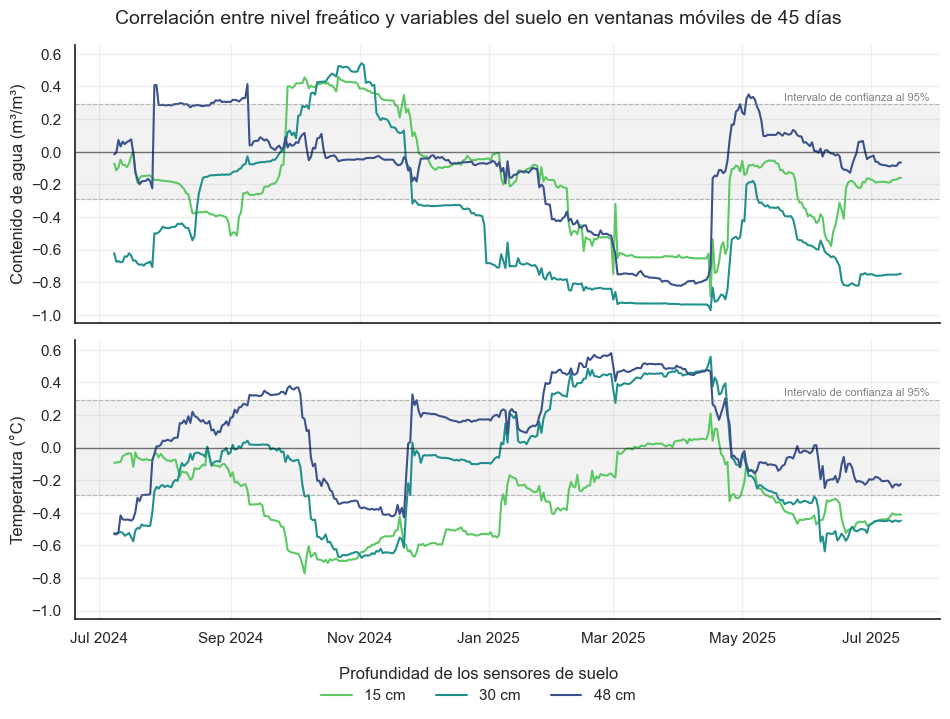

In [164]:
# Creacion de la figura base
roll_corr = sns.relplot(
    data=rolling_corr_df,
    x='Timestamps',
    y='Rolling-correlation',
    hue='Depth-label',
    row='Variable-label',
    palette=palette_dict,
    kind='line',
    height=3.5,
    aspect=2.5
)

# Eliminacion de elementos incluidos por defecto
roll_corr.set_titles('')
roll_corr.set_xlabels('')
roll_corr._legend.remove()

# Iteracion sobre facets para etiquetar los ejes Y
for ax, title in zip(roll_corr.axes.flat, roll_corr.row_names):
    ax.set_ylabel(title)

# Formateo de fechas en el eje X
    date_format = mdates.DateFormatter('%b %Y')
    ax.xaxis.set_major_formatter(date_format)

# Trazado de lineas de referencia
for ax in roll_corr.axes.flat:

    # Trazado de linea 0
    ax.axhline(0, color='black', linestyle='-', linewidth=1, alpha=0.5)

    # Trazado de limites de confianza
    ax.axhline(conf_rolling_corr, color='gray', linestyle='--', linewidth=0.8, alpha=0.5)
    ax.axhline(-conf_rolling_corr, color='gray', linestyle='--', linewidth=0.8, alpha=0.5)
    ax.axhspan(-conf_rolling_corr, conf_rolling_corr, color='gray', alpha=0.1)

    # Anotacion del limite de confianza
    ax.text(
        x=0.82,
        y=0.8,
        s='Intervalo de confianza al 95%',
        transform=ax.transAxes,
        fontsize=8,
        color='gray'
    )    

# Creacion de nueva leyenda
roll_corr.figure.legend(
    loc='lower center',
    bbox_to_anchor=(0.5, -0.03),
    ncol=3,
    title="Profundidad de los sensores de suelo",
    frameon=False
)

# Establecimiento de titulo
roll_corr.figure.suptitle(f'Correlación entre nivel freático y variables del suelo en ventanas móviles de {window_days} días', 
                           x=0.5, y=0.98, fontsize=14)

# Ajustes de espaciado
plt.tight_layout()
plt.subplots_adjust(top=0.93, bottom=0.11) # Ajusta espacio disponible para facets

plt.show()

##### Diagrama de Hovmoller

In [169]:
# Definicion de funcion para generar un mapa de calor
def heatmap(data, **kwargs):
    
    # Pivoteo de los datos largos a matriz. La funcion de mapeo de heatmap
    # de matplotlib (pcolormesh) requiere datos en formato ancho
    pivot_data = data.pivot(index='Depth_m', columns='Date', values='Value')

    # Defincion de objetos que guardan los elementos de la matriz
    X = pivot_data.columns  # Fechas
    Y = pivot_data.index    # Profundidades
    Z = pivot_data.values   # Valores

    # Asignacion condicional de colores y etiquetas segun variable
    variable = data['Variable-label'].iloc[0]
    if 'Temperatura (°C)' in variable:
        palette = 'OrRd'
        label = 'Temperatura (°C)'
    else:
        palette = 'PuBu'
        label = 'Contenido de agua (m³/m³)'

    # Renderizado de la grilla interpolada usando pcolormesh
    mesh = plt.pcolormesh(X, Y, Z, cmap=palette, shading='auto')

    # Definicion del objeto ax
    ax = plt.gca()

    # Trazado de nivel freatico en los axes
    gw_df = kwargs.get('groundwater_data')
    col_piezo = 'Piezometer_NA_groundwater-depth_m' 
    ax.plot(
        gw_df.index, 
        gw_df[col_piezo], 
        color='black',
       linestyle='-',
        linewidth=1.5,
        label='Nivel freático'
        )

    # Creacion de leyenda
    cbar = plt.colorbar(mesh, 
                 ax=ax, 
                 label=label, 
                 pad=0.02, 
                 aspect=10,
                 shrink=0.7)
    cbar.set_label(
        label, 
        rotation=-90,
        labelpad=15
        )

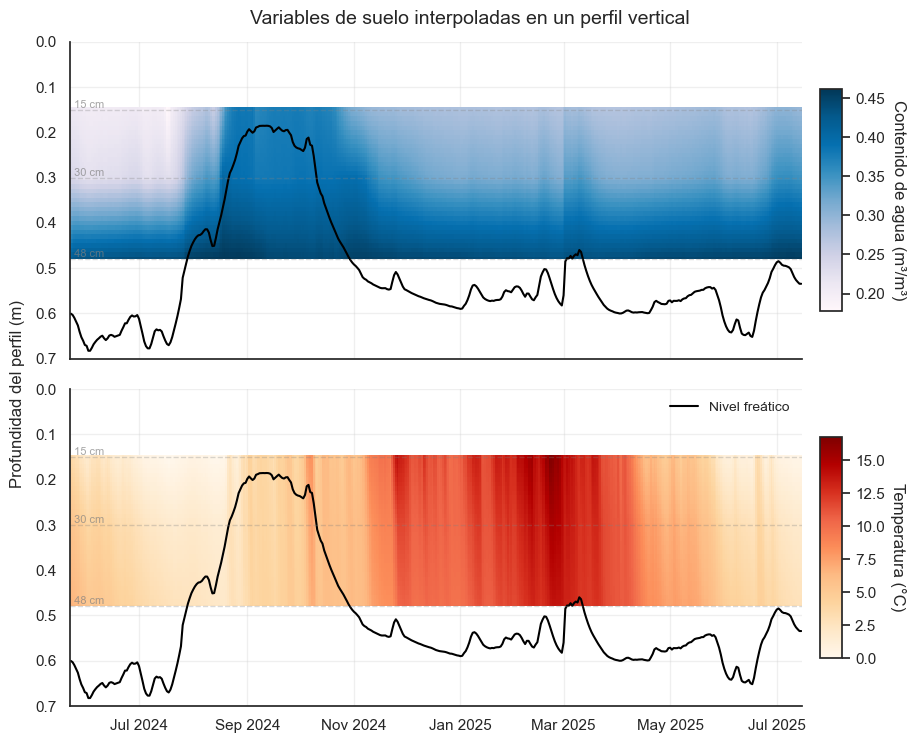

In [170]:
# Creacion de la figura base
hovmoller = sns.FacetGrid(
    data=hovmoller_df,
    row='Variable-label',
    height=4,
    aspect=2.5,
    sharex=True,
    sharey=True
)

# Mapeo del heatmap
hovmoller.map_dataframe(heatmap, groundwater_data=wide_df)

# Eliminacion de elementos incluidos por defecto
hovmoller.set_titles('')

# Iteracion sobre facets
for i, ax in enumerate(hovmoller.axes.flat):
    
    # Añadido de leyenda del nivel freatico 
    if i == 1:
        ax.legend(loc='upper right', frameon=False, fontsize='small', framealpha=0.8)
    
    # Formateo de fecha
    date_fmt = mdates.DateFormatter('%b %Y')
    ax.xaxis.set_major_formatter(date_fmt)

    # Añadido de profundidad de sensores
    for d in [0.15, 0.30, 0.48]:
        ax.axhline(d, color='gray', linestyle='--', alpha=0.3, linewidth=1)
        ax.text(wide_df.index[0], d, f' {d*100:.0f} cm', color='gray', va='bottom', fontsize=8, alpha=0.7)

# Inversion del eje Y
y_min, y_max = 0, 0.7
hovmoller.set(ylim=(y_max, y_min))

# Etiquetado del eje Y
hovmoller.figure.supylabel(
    'Profundidad del perfil (m)',
    x=0.04,
    size=plt.rcParams['axes.labelsize'], # Igualar tamaño al eje X
    )

# Establecimiento del titulo
hovmoller.figure.suptitle("Variables de suelo interpoladas en un perfil vertical",
                            x=0.5, y=0.98, fontsize=14)

# Ajustes de espaciado
plt.tight_layout()
plt.subplots_adjust(top=0.94, bottom=0.11, left=0.1) # Ajusta espacio disponible para facets

plt.show()